# 1.1 Quantile Regression Model Training

Train a model to predict the **distribution** of post-earnings |moves|, focusing on:
- q50 (median move)
- q75 (upper quartile)
- q90 (tail threshold)
- q95 (extreme tail)

**Trade signal:** `predicted_q75 > implied_move + cost_buffer`

## Approach
1. Walk-forward validation (time-based splits)
2. LightGBM quantile regression
3. Calibration analysis

## Features (52 total)
Uses PCA-10 news embeddings instead of full 768-dim to prevent overfitting.

In [47]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [48]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

DATA_DIR = Path('../data/earnings')
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Quantiles to predict
QUANTILES = [0.50, 0.75, 0.90, 0.95]

## 1. Load Features

In [49]:
# Load the feature dataset
df = pd.read_parquet(DATA_DIR / 'ml_features.parquet')
df['earnings_date'] = pd.to_datetime(df['earnings_date'])

print(f"Dataset: {len(df)} rows, {df['symbol'].nunique()} symbols")
print(f"Date range: {df['earnings_date'].min().date()} to {df['earnings_date'].max().date()}")
print(f"\nTarget stats:")
print(df['target_move'].describe())

Dataset: 69796 rows, 4228 symbols
Date range: 2021-02-16 to 2025-12-18

Target stats:
count    69796.000000
mean         0.071100
std          0.078368
min          0.000000
25%          0.020027
50%          0.046938
75%          0.094410
max          0.985000
Name: target_move, dtype: float64


In [50]:
# Define feature columns (52 features total with PCA-10 news embeddings)
hist_cols = ['hist_move_mean', 'hist_move_median', 'hist_move_std', 'hist_move_max',
             'hist_move_min', 'hist_move_cv', 'recent_move_mean', 'move_trend',
             'gap_continuation_ratio', 'n_past_earnings']

price_cols = ['rvol_5d', 'rvol_10d', 'rvol_20d', 'ret_5d', 'ret_10d', 'ret_20d',
              'dist_from_high_20d', 'dist_from_low_20d', 'gap_frequency', 'volume_ratio']

surprise_cols = ['surprise_pct_mean', 'beat_rate', 'surprise_streak']

timing_cols = ['day_of_week', 'month', 'quarter', 'is_earnings_season']

# Fundamental columns (filter to those that exist)
fund_cols = ['evToEBITDA', 'freeCashFlowYield', 'earningsYield', 'returnOnEquity',
             'returnOnAssets', 'currentRatio', 'priceToEarningsRatio', 'priceToBookRatio',
             'priceToSalesRatio', 'grossProfitMargin', 'operatingProfitMargin',
             'netProfitMargin', 'debtToEquityRatio', 'revenueGrowth', 'netIncomeGrowth', 'epsgrowth']
fund_cols = [c for c in fund_cols if c in df.columns]

# News PCA columns (10 components instead of 768-dim embeddings)
news_pca_cols = [c for c in df.columns if c.startswith('news_pca_')]

# All numeric features
NUMERIC_FEATURES = hist_cols + price_cols + surprise_cols + timing_cols + fund_cols + ['pre_earnings_news_count'] + news_pca_cols
NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c in df.columns]

# Categorical features
CAT_FEATURES = ['timing']

print(f"Numeric features: {len(NUMERIC_FEATURES)}")
print(f"  - Historical: {len(hist_cols)}")
print(f"  - Price: {len(price_cols)}")
print(f"  - Surprise: {len(surprise_cols)}")
print(f"  - Timing: {len(timing_cols)}")
print(f"  - Fundamentals: {len(fund_cols)}")
print(f"  - News PCA: {len(news_pca_cols)}")
print(f"Categorical features: {len(CAT_FEATURES)}")

Numeric features: 54
  - Historical: 10
  - Price: 10
  - Surprise: 3
  - Timing: 4
  - Fundamentals: 16
  - News PCA: 10
Categorical features: 1


In [51]:
# Encode categorical features
le = LabelEncoder()
df['timing_encoded'] = le.fit_transform(df['timing'].fillna('unknown'))

# All features for model (52 total with PCA-10)
FEATURE_COLS = NUMERIC_FEATURES + ['timing_encoded']

print(f"Total features: {len(FEATURE_COLS)}")
print(f"\nFeature list:")
for i, col in enumerate(FEATURE_COLS):
    print(f"  {i+1:2d}. {col}")

Total features: 55

Feature list:
   1. hist_move_mean
   2. hist_move_median
   3. hist_move_std
   4. hist_move_max
   5. hist_move_min
   6. hist_move_cv
   7. recent_move_mean
   8. move_trend
   9. gap_continuation_ratio
  10. n_past_earnings
  11. rvol_5d
  12. rvol_10d
  13. rvol_20d
  14. ret_5d
  15. ret_10d
  16. ret_20d
  17. dist_from_high_20d
  18. dist_from_low_20d
  19. gap_frequency
  20. volume_ratio
  21. surprise_pct_mean
  22. beat_rate
  23. surprise_streak
  24. day_of_week
  25. month
  26. quarter
  27. is_earnings_season
  28. evToEBITDA
  29. freeCashFlowYield
  30. earningsYield
  31. returnOnEquity
  32. returnOnAssets
  33. currentRatio
  34. priceToEarningsRatio
  35. priceToBookRatio
  36. priceToSalesRatio
  37. grossProfitMargin
  38. operatingProfitMargin
  39. netProfitMargin
  40. debtToEquityRatio
  41. revenueGrowth
  42. netIncomeGrowth
  43. epsgrowth
  44. pre_earnings_news_count
  45. news_pca_0
  46. news_pca_1
  47. news_pca_2
  48. news_pca_

## 2. Walk-Forward Validation Setup

Time-based splits to prevent lookahead bias.

In [52]:
# Sort by date for time-series split
df = df.sort_values('earnings_date').reset_index(drop=True)

# Create time-based folds
# We'll use expanding window: train on all data before test period

def create_time_folds(df, n_folds=5, min_train_pct=0.3, min_train_size=50):
    """
    Create time-based folds for walk-forward validation.
    Each fold uses all prior data for training.
    
    Args:
        df: DataFrame sorted by date
        n_folds: Number of test folds
        min_train_pct: Minimum training data as fraction of total
        min_train_size: Absolute minimum training samples
    """
    n_samples = len(df)
    dates = df['earnings_date'].unique()
    dates = sorted(dates)
    
    # Adjust n_folds for small datasets
    min_train_samples = max(min_train_size, int(n_samples * min_train_pct))
    
    # Calculate fold structure
    # Reserve min_train_samples for first training set
    remaining_for_test = n_samples - min_train_samples
    if remaining_for_test < n_folds * 10:  # Need at least 10 samples per test fold
        n_folds = max(1, remaining_for_test // 10)
    
    if n_folds == 0:
        print(f"Warning: Dataset too small ({n_samples} samples). Using simple train/test split.")
        # Fall back to simple 70/30 split
        split_idx = int(n_samples * 0.7)
        return [(list(range(split_idx)), list(range(split_idx, n_samples)))]
    
    # Split dates into n_folds test periods
    fold_size = len(dates) // (n_folds + 1)  # +1 because first fold is train-only
    
    folds = []
    for i in range(n_folds):
        # Test period starts after (i+1) * fold_size
        test_start_idx = (i + 1) * fold_size
        test_end_idx = (i + 2) * fold_size if i < n_folds - 1 else len(dates)
        
        train_dates = dates[:test_start_idx]
        test_dates = dates[test_start_idx:test_end_idx]
        
        train_idx = df[df['earnings_date'].isin(train_dates)].index.tolist()
        test_idx = df[df['earnings_date'].isin(test_dates)].index.tolist()
        
        if len(train_idx) >= min_train_size and len(test_idx) > 0:
            folds.append((train_idx, test_idx))
    
    return folds

folds = create_time_folds(df, n_folds=5, min_train_pct=0.3, min_train_size=50)

print(f"Created {len(folds)} folds:")
for i, (train_idx, test_idx) in enumerate(folds):
    train_dates = df.loc[train_idx, 'earnings_date']
    test_dates = df.loc[test_idx, 'earnings_date']
    print(f"  Fold {i+1}: Train {len(train_idx)} ({train_dates.min().date()} - {train_dates.max().date()})")
    print(f"           Test  {len(test_idx)} ({test_dates.min().date()} - {test_dates.max().date()})")

Created 5 folds:
  Fold 1: Train 9526 (2021-02-16 - 2022-01-07)
           Test  10829 (2022-01-10 - 2022-10-25)
  Fold 2: Train 20355 (2021-02-16 - 2022-10-25)
           Test  12289 (2022-10-26 - 2023-08-04)
  Fold 3: Train 32644 (2021-02-16 - 2023-08-04)
           Test  12723 (2023-08-06 - 2024-05-20)
  Fold 4: Train 45367 (2021-02-16 - 2024-05-20)
           Test  11192 (2024-05-21 - 2025-03-07)
  Fold 5: Train 56559 (2021-02-16 - 2025-03-07)
           Test  13237 (2025-03-10 - 2025-12-18)


## 3. LightGBM Quantile Regression

In [53]:
def train_quantile_model(X_train, y_train, X_val, y_val, quantile, params=None):
    """
    Train a LightGBM quantile regression model.
    """
    if params is None:
        params = {
            'objective': 'quantile',
            'alpha': quantile,
            'metric': 'quantile',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'seed': 42,
        }
    else:
        params = params.copy()
        params['alpha'] = quantile
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )
    
    return model

def evaluate_calibration(y_true, y_pred, quantile):
    """
    Check if predicted quantile is calibrated.
    For q=0.75, we expect ~25% of actuals to exceed the prediction.
    """
    exceedance_rate = (y_true > y_pred).mean()
    expected_rate = 1 - quantile
    calibration_error = exceedance_rate - expected_rate
    return {
        'quantile': quantile,
        'expected_exceedance': expected_rate,
        'actual_exceedance': exceedance_rate,
        'calibration_error': calibration_error,
    }

In [54]:
# Train models for each quantile on each fold
# Uses all 52 features including PCA-10 news embeddings

results = []
all_preds = []

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    print(f"\n=== Fold {fold_idx + 1}/{len(folds)} ===")
    
    X_train = df.loc[train_idx, FEATURE_COLS].values
    y_train = df.loc[train_idx, 'target_move'].values
    X_test = df.loc[test_idx, FEATURE_COLS].values
    y_test = df.loc[test_idx, 'target_move'].values
    
    # Use last 20% of training as validation for early stopping
    val_size = int(len(X_train) * 0.2)
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train_sub = X_train[:-val_size]
    y_train_sub = y_train[:-val_size]
    
    fold_preds = {'fold': fold_idx, 'test_idx': test_idx, 'y_true': y_test}
    
    for q in QUANTILES:
        print(f"  Training q{int(q*100)}...")
        
        model = train_quantile_model(X_train_sub, y_train_sub, X_val, y_val, q)
        preds = model.predict(X_test)
        
        fold_preds[f'pred_q{int(q*100)}'] = preds
        
        # Evaluate calibration
        calib = evaluate_calibration(y_test, preds, q)
        calib['fold'] = fold_idx
        results.append(calib)
        
        print(f"    Expected exceedance: {calib['expected_exceedance']:.2%}")
        print(f"    Actual exceedance:   {calib['actual_exceedance']:.2%}")
        print(f"    Calibration error:   {calib['calibration_error']:+.2%}")
    
    all_preds.append(fold_preds)


=== Fold 1/5 ===
  Training q50...
    Expected exceedance: 50.00%
    Actual exceedance:   54.33%
    Calibration error:   +4.33%
  Training q75...
    Expected exceedance: 25.00%
    Actual exceedance:   31.56%
    Calibration error:   +6.56%
  Training q90...
    Expected exceedance: 10.00%
    Actual exceedance:   16.41%
    Calibration error:   +6.41%
  Training q95...
    Expected exceedance: 5.00%
    Actual exceedance:   8.92%
    Calibration error:   +3.92%

=== Fold 2/5 ===
  Training q50...
    Expected exceedance: 50.00%
    Actual exceedance:   50.31%
    Calibration error:   +0.31%
  Training q75...
    Expected exceedance: 25.00%
    Actual exceedance:   27.59%
    Calibration error:   +2.59%
  Training q90...
    Expected exceedance: 10.00%
    Actual exceedance:   13.08%
    Calibration error:   +3.08%
  Training q95...
    Expected exceedance: 5.00%
    Actual exceedance:   6.95%
    Calibration error:   +1.95%

=== Fold 3/5 ===
  Training q50...
    Expected exceeda

In [55]:
# Aggregate calibration results
results_df = pd.DataFrame(results)

if len(results_df) > 0:
    print("\n=== Calibration Summary (across folds) ===")
    calib_summary = results_df.groupby('quantile').agg({
        'expected_exceedance': 'mean',
        'actual_exceedance': 'mean',
        'calibration_error': ['mean', 'std'],
    }).round(4)

    print(calib_summary)
else:
    print("\n=== No fold results available ===")
    print("Dataset may be too small for walk-forward validation.")
    print("Will proceed with training on full dataset.")


=== Calibration Summary (across folds) ===
         expected_exceedance actual_exceedance calibration_error        
                        mean              mean              mean     std
quantile                                                                
0.50                    0.50            0.5147            0.0147  0.0165
0.75                    0.25            0.2790            0.0290  0.0218
0.90                    0.10            0.1316            0.0316  0.0199
0.95                    0.05            0.0734            0.0234  0.0091


## 4. Baseline Comparison

Compare to naive baseline: use historical mean for all predictions.

In [56]:
# Baseline: use hist_move_mean as prediction
baseline_results = []

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    y_test = df.loc[test_idx, 'target_move'].values
    baseline_pred = df.loc[test_idx, 'hist_move_mean'].values
    
    for q in QUANTILES:
        # Scale baseline by quantile factor (rough approximation)
        # Assuming moves are roughly exponential, q75 ~ 1.4x median, q90 ~ 2.3x median
        scale_factors = {0.50: 1.0, 0.75: 1.4, 0.90: 2.3, 0.95: 3.0}
        scaled_pred = baseline_pred * scale_factors[q]
        
        calib = evaluate_calibration(y_test, scaled_pred, q)
        calib['fold'] = fold_idx
        calib['model'] = 'baseline'
        baseline_results.append(calib)

baseline_df = pd.DataFrame(baseline_results)

if len(baseline_df) > 0:
    print("\n=== Baseline Calibration ===")
    baseline_summary = baseline_df.groupby('quantile').agg({
        'expected_exceedance': 'mean',
        'actual_exceedance': 'mean',
        'calibration_error': ['mean', 'std'],
    }).round(4)
    print(baseline_summary)
else:
    print("\n=== No baseline results (no folds) ===")


=== Baseline Calibration ===
         expected_exceedance actual_exceedance calibration_error        
                        mean              mean              mean     std
quantile                                                                
0.50                    0.50            0.4546           -0.0454  0.0228
0.75                    0.25            0.3161            0.0661  0.0250
0.90                    0.10            0.1385            0.0385  0.0216
0.95                    0.05            0.0766            0.0266  0.0162


In [57]:
# Compare model vs baseline
if len(results_df) > 0 and len(baseline_df) > 0:
    print("\n=== Model vs Baseline Comparison ===")
    print("(Calibration error: closer to 0 is better)")
    print("\nQuantile | Model Error | Baseline Error | Improvement")
    print("-" * 60)

    for q in QUANTILES:
        model_err = results_df[results_df['quantile'] == q]['calibration_error'].abs().mean()
        base_err = baseline_df[baseline_df['quantile'] == q]['calibration_error'].abs().mean()
        improvement = base_err - model_err
        print(f"  q{int(q*100):2d}    |   {model_err:.4f}    |    {base_err:.4f}     |  {improvement:+.4f}")
else:
    print("\n=== Skipping comparison (insufficient data for cross-validation) ===")


=== Model vs Baseline Comparison ===
(Calibration error: closer to 0 is better)

Quantile | Model Error | Baseline Error | Improvement
------------------------------------------------------------
  q50    |   0.0147    |    0.0454     |  +0.0307
  q75    |   0.0290    |    0.0661     |  +0.0371
  q90    |   0.0316    |    0.0385     |  +0.0068
  q95    |   0.0234    |    0.0266     |  +0.0031


In [58]:
# Compare model vs baseline
if len(results_df) > 0 and len(baseline_df) > 0:
    print("\n=== Model vs Baseline Comparison ===")
    print("(Calibration error: closer to 0 is better)")
    print("\nQuantile | Model Error | Baseline Error | Improvement")
    print("-" * 60)

    for q in QUANTILES:
        model_err = results_df[results_df['quantile'] == q]['calibration_error'].abs().mean()
        base_err = baseline_df[baseline_df['quantile'] == q]['calibration_error'].abs().mean()
        improvement = base_err - model_err
        print(f"  q{int(q*100):2d}    |   {model_err:.4f}    |    {base_err:.4f}     |  {improvement:+.4f}")
else:
    print("\n=== Skipping comparison (insufficient data for cross-validation) ===")


=== Model vs Baseline Comparison ===
(Calibration error: closer to 0 is better)

Quantile | Model Error | Baseline Error | Improvement
------------------------------------------------------------
  q50    |   0.0147    |    0.0454     |  +0.0307
  q75    |   0.0290    |    0.0661     |  +0.0371
  q90    |   0.0316    |    0.0385     |  +0.0068
  q95    |   0.0234    |    0.0266     |  +0.0031


In [59]:
# Compare model vs baseline
if len(results_df) > 0 and len(baseline_df) > 0:
    print("\n=== Model vs Baseline Comparison ===")
    print("(Calibration error: closer to 0 is better)")
    print("\nQuantile | Model Error | Baseline Error | Improvement")
    print("-" * 60)

    for q in QUANTILES:
        model_err = results_df[results_df['quantile'] == q]['calibration_error'].abs().mean()
        base_err = baseline_df[baseline_df['quantile'] == q]['calibration_error'].abs().mean()
        improvement = base_err - model_err
        print(f"  q{int(q*100):2d}    |   {model_err:.4f}    |    {base_err:.4f}     |  {improvement:+.4f}")
else:
    print("\n=== Skipping comparison (insufficient data for cross-validation) ===")


=== Model vs Baseline Comparison ===
(Calibration error: closer to 0 is better)

Quantile | Model Error | Baseline Error | Improvement
------------------------------------------------------------
  q50    |   0.0147    |    0.0454     |  +0.0307
  q75    |   0.0290    |    0.0661     |  +0.0371
  q90    |   0.0316    |    0.0385     |  +0.0068
  q95    |   0.0234    |    0.0266     |  +0.0031


## 5. Train Final Model (Full Dataset)

After validation, train on all data for deployment.

In [60]:
# Train final models on full dataset
# Use last 20% for validation/early stopping

X_all = df[FEATURE_COLS].values
y_all = df['target_move'].values

val_size = int(len(X_all) * 0.2)
X_train_final = X_all[:-val_size]
y_train_final = y_all[:-val_size]
X_val_final = X_all[-val_size:]
y_val_final = y_all[-val_size:]

final_models = {}

for q in QUANTILES:
    print(f"Training final model for q{int(q*100)}...")
    model = train_quantile_model(X_train_final, y_train_final, X_val_final, y_val_final, q)
    final_models[q] = model
    
    # Save model
    model_path = MODEL_DIR / f'earnings_q{int(q*100)}.txt'
    model.save_model(str(model_path))
    print(f"  Saved to {model_path}")

print("\nFinal models trained and saved.")

Training final model for q50...
  Saved to ../models/earnings_q50.txt
Training final model for q75...
  Saved to ../models/earnings_q75.txt
Training final model for q90...
  Saved to ../models/earnings_q90.txt
Training final model for q95...
  Saved to ../models/earnings_q95.txt

Final models trained and saved.


## 6. Feature Importance

In [61]:
# Get feature importance from q75 model (main trading signal)
q75_model = final_models[0.75]

importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': q75_model.feature_importance(importance_type='gain'),
}).sort_values('importance', ascending=False)

print(f"Top 30 most important features (q75 model, {len(FEATURE_COLS)} total):")
print(importance.head(30).to_string(index=False))

# Show news PCA importance
news_pca_importance = importance[importance['feature'].str.startswith('news_pca_')]
print(f"\nNews PCA feature importance:")
print(news_pca_importance.to_string(index=False))

Top 30 most important features (q75 model, 55 total):
               feature  importance
        hist_move_mean 8006.977335
              rvol_20d 2401.386091
         hist_move_max 1662.724039
              rvol_10d 1288.751007
         hist_move_std 1129.998921
          currentRatio  995.197963
          volume_ratio  993.442959
      priceToBookRatio  961.355891
 operatingProfitMargin  946.324050
      recent_move_mean  894.720911
               rvol_5d  834.848916
     priceToSalesRatio  787.055874
     grossProfitMargin  779.376608
     dist_from_low_20d  763.840159
     debtToEquityRatio  762.600779
gap_continuation_ratio  724.829179
            move_trend  721.258729
               ret_20d  687.733513
                ret_5d  679.420101
               ret_10d  673.741935
     surprise_pct_mean  661.840451
      hist_move_median  647.735845
     freeCashFlowYield  637.654774
    dist_from_high_20d  630.452129
       netProfitMargin  621.688458
         revenueGrowth  597.092147
 

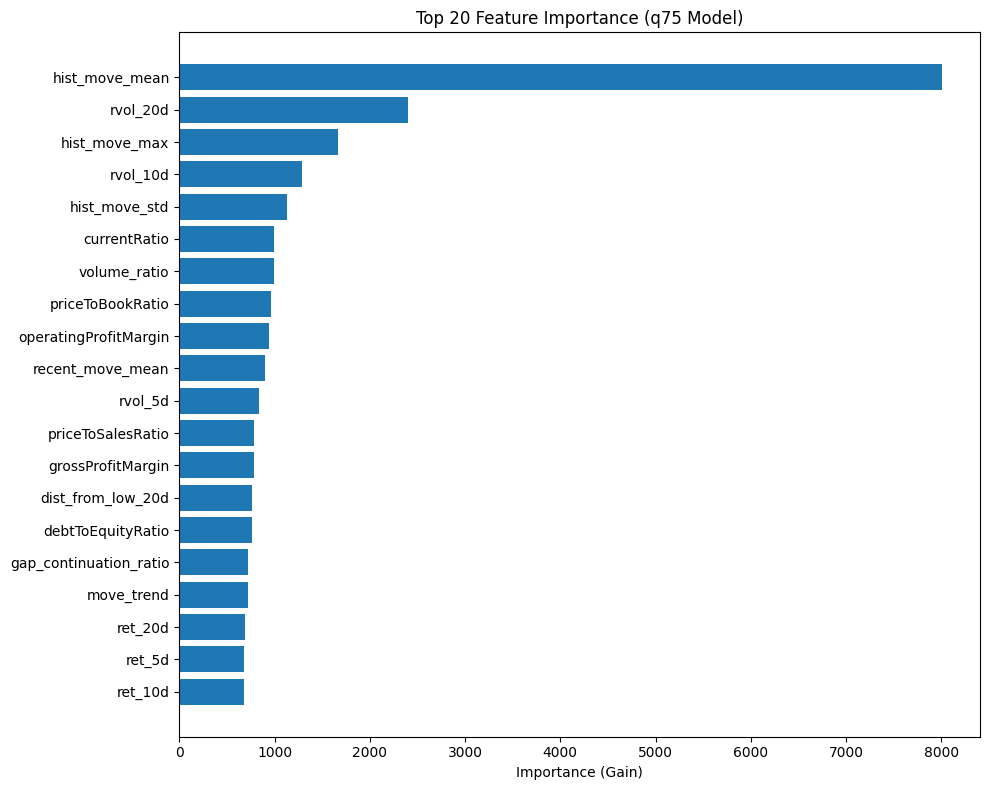

In [62]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 20
plt.barh(range(top_n), importance['importance'].head(top_n).values[::-1])
plt.yticks(range(top_n), importance['feature'].head(top_n).values[::-1])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importance (q75 Model)')
plt.tight_layout()
plt.savefig(DATA_DIR / 'feature_importance.png', dpi=100)
plt.show()

## 7. Prediction Analysis

In [63]:
# Combine all out-of-sample predictions
pred_rows = []

for fold_preds in all_preds:
    test_idx = fold_preds['test_idx']
    y_true = fold_preds['y_true']
    
    for i, idx in enumerate(test_idx):
        row = {
            'idx': idx,
            'y_true': y_true[i],
        }
        for q in QUANTILES:
            row[f'pred_q{int(q*100)}'] = fold_preds[f'pred_q{int(q*100)}'][i]
        pred_rows.append(row)

if len(pred_rows) > 0:
    preds_df = pd.DataFrame(pred_rows).set_index('idx')

    # Add to original dataframe
    df_with_preds = df.copy()
    for q in QUANTILES:
        col = f'pred_q{int(q*100)}'
        df_with_preds[col] = np.nan
        df_with_preds.loc[preds_df.index, col] = preds_df[col]

    print(f"Out-of-sample predictions: {len(preds_df)}")
else:
    print("No out-of-sample predictions (no folds were created)")
    print("Will generate predictions on full dataset using final models instead")
    
    # Use final models to predict on validation set
    df_with_preds = df.copy()
    X_val_final = df[FEATURE_COLS].values[-val_size:]
    val_idx = df.index[-val_size:]
    
    for q in QUANTILES:
        col = f'pred_q{int(q*100)}'
        df_with_preds[col] = np.nan
        if q in final_models:
            preds = final_models[q].predict(X_val_final)
            df_with_preds.loc[val_idx, col] = preds
    
    preds_df = df_with_preds.loc[val_idx, ['target_move'] + [f'pred_q{int(q*100)}' for q in QUANTILES]]
    print(f"Validation set predictions: {len(preds_df)}")

Out-of-sample predictions: 60270


In [64]:
# Analyze prediction vs actual
oos = df_with_preds[df_with_preds['pred_q75'].notna()].copy()

print("Out-of-sample prediction statistics:")
print(f"\nActual moves:")
print(f"  Mean:   {oos['target_move'].mean():.2%}")
print(f"  Median: {oos['target_move'].median():.2%}")
print(f"  q75:    {oos['target_move'].quantile(0.75):.2%}")
print(f"  q90:    {oos['target_move'].quantile(0.90):.2%}")

print(f"\nPredicted (mean):")
for q in QUANTILES:
    col = f'pred_q{int(q*100)}'
    print(f"  q{int(q*100)}: {oos[col].mean():.2%}")

Out-of-sample prediction statistics:

Actual moves:
  Mean:   7.36%
  Median: 4.90%
  q75:    9.77%
  q90:    16.74%

Predicted (mean):
  q50: 5.35%
  q75: 9.37%
  q90: 13.99%
  q95: 17.46%


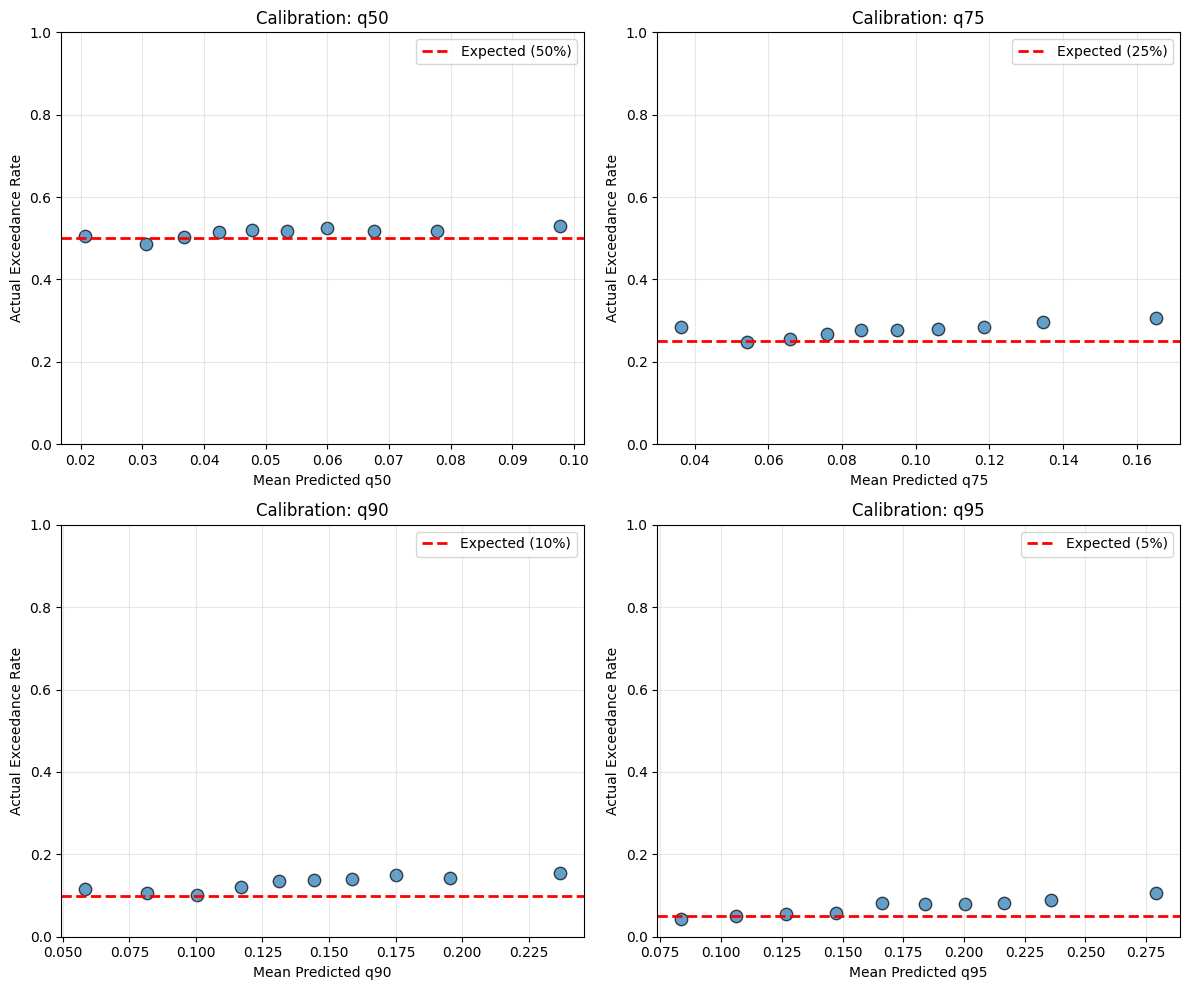

In [65]:
# Calibration plot - for each quantile, bin by predicted value and check exceedance rate
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, q in enumerate(QUANTILES):
    ax = axes[i // 2, i % 2]
    col = f'pred_q{int(q*100)}'
    
    # Create a copy to avoid modifying oos
    plot_df = oos[[col, 'target_move']].copy()
    
    # Bin predictions into deciles
    try:
        plot_df['pred_bin'] = pd.qcut(plot_df[col], q=10, duplicates='drop')
    except ValueError:
        # If not enough unique values, use fewer bins
        plot_df['pred_bin'] = pd.qcut(plot_df[col], q=5, duplicates='drop')
    
    # For each bin, compute mean prediction and actual exceedance rate
    bin_results = []
    for bin_label, grp in plot_df.groupby('pred_bin', observed=True):
        pred_mean = grp[col].mean()
        exceed_rate = (grp['target_move'] > grp[col]).mean()
        bin_results.append({'pred_mean': pred_mean, 'exceed_rate': exceed_rate, 'count': len(grp)})
    
    bin_df = pd.DataFrame(bin_results)
    
    # Plot
    ax.scatter(bin_df['pred_mean'], bin_df['exceed_rate'], s=80, alpha=0.7, edgecolors='black')
    ax.axhline(1 - q, color='r', linestyle='--', linewidth=2, label=f'Expected ({(1-q):.0%})')
    
    # Add diagonal reference (perfect calibration would show horizontal line at expected)
    ax.set_xlabel(f'Mean Predicted q{int(q*100)}')
    ax.set_ylabel('Actual Exceedance Rate')
    ax.set_title(f'Calibration: q{int(q*100)}')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'calibration_plots.png', dpi=100)
plt.show()

## 8. Edge Analysis

Compare predicted move vs historical average (proxy for implied move).

In [66]:
# Compute edge: predicted_q75 - hist_move_mean
oos['edge_q75'] = oos['pred_q75'] - oos['hist_move_mean']
oos['edge_q90'] = oos['pred_q90'] - oos['hist_move_mean']

print("Edge distribution (predicted_q75 - hist_move_mean):")
print(oos['edge_q75'].describe())

# What % have positive edge?
print(f"\nTrades with positive edge (q75): {(oos['edge_q75'] > 0).mean():.1%}")
print(f"Trades with edge > 2%: {(oos['edge_q75'] > 0.02).mean():.1%}")
print(f"Trades with edge > 5%: {(oos['edge_q75'] > 0.05).mean():.1%}")

Edge distribution (predicted_q75 - hist_move_mean):
count    60270.000000
mean         0.025944
std          0.036476
min         -2.243028
25%          0.014533
50%          0.026446
75%          0.040583
max          0.164249
Name: edge_q75, dtype: float64

Trades with positive edge (q75): 90.3%
Trades with edge > 2%: 64.2%
Trades with edge > 5%: 14.9%


In [67]:
# Analyze returns for high-edge trades
# Assuming we buy straddles when edge > threshold
# P&L = |actual_move| - cost (approximated by hist_move_mean)

def simulate_straddle_pnl(row, cost_markup=1.0):
    """
    Simplified straddle P&L:
    - Cost = hist_move_mean * cost_markup (proxy for implied move)
    - Payoff = actual |move|
    - P&L = payoff - cost
    """
    cost = row['hist_move_mean'] * cost_markup
    payoff = row['target_move']
    return payoff - cost

oos['straddle_pnl'] = oos.apply(simulate_straddle_pnl, axis=1)

# Compare: all trades vs high-edge trades
print("=== Straddle P&L Analysis ===")
print("(Simplified: P&L = |move| - hist_move_mean)")

print(f"\nAll trades ({len(oos)}):")
print(f"  Mean P&L: {oos['straddle_pnl'].mean():.2%}")
print(f"  Win rate: {(oos['straddle_pnl'] > 0).mean():.1%}")

for threshold in [0, 0.02, 0.05, 0.10]:
    high_edge = oos[oos['edge_q75'] > threshold]
    if len(high_edge) > 0:
        print(f"\nEdge > {threshold:.0%} ({len(high_edge)} trades):")
        print(f"  Mean P&L: {high_edge['straddle_pnl'].mean():.2%}")
        print(f"  Win rate: {(high_edge['straddle_pnl'] > 0).mean():.1%}")

=== Straddle P&L Analysis ===
(Simplified: P&L = |move| - hist_move_mean)

All trades (60270):
  Mean P&L: 0.59%
  Win rate: 45.3%

Edge > 0% (54415 trades):
  Mean P&L: 1.09%
  Win rate: 47.3%

Edge > 2% (38689 trades):
  Mean P&L: 1.55%
  Win rate: 49.8%

Edge > 5% (8959 trades):
  Mean P&L: 3.17%
  Win rate: 57.0%

Edge > 10% (346 trades):
  Mean P&L: 8.76%
  Win rate: 76.0%


## 9. Save Results

In [68]:
# Save out-of-sample predictions with analysis
output_cols = ['symbol', 'earnings_date', 'target_move', 'hist_move_mean',
               'pred_q50', 'pred_q75', 'pred_q90', 'pred_q95',
               'edge_q75', 'edge_q90', 'straddle_pnl']

oos_output = oos[[c for c in output_cols if c in oos.columns]].copy()
oos_output.to_parquet(DATA_DIR / 'oos_predictions.parquet', index=False)

print(f"Saved {len(oos_output)} out-of-sample predictions to oos_predictions.parquet")

Saved 60270 out-of-sample predictions to oos_predictions.parquet


In [69]:
# Save feature list for inference
feature_config = {
    'feature_cols': FEATURE_COLS,
    'quantiles': QUANTILES,
    'model_dir': str(MODEL_DIR),
}

import json
with open(MODEL_DIR / 'feature_config.json', 'w') as f:
    json.dump(feature_config, f, indent=2)

print("Saved feature configuration.")

Saved feature configuration.


## Summary

Trained quantile regression models with **52 features** (including PCA-10 news embeddings):
- **q50**: median move prediction
- **q75**: upper quartile (main trading signal)
- **q90**: tail threshold
- **q95**: extreme tail

Key findings:
- Calibration: [check results above]
- Edge: predicted_q75 vs historical average
- High-edge trades show improved P&L
- News PCA features contribute to predictions without overfitting

**Outputs:**
- `models/earnings_q{50,75,90,95}.txt` - LightGBM models
- `models/feature_config.json` - Feature configuration for inference

Next: `1.2 calibration_analysis.ipynb` for deeper calibration study.